In [1]:
%load_ext autoreload
%autoreload 2

from model.feedforward import FeedForwardLayer
import torch
from model.attention import MultiHeadAttention
from model.posencoding import RoPE

In [2]:
ffl = FeedForwardLayer(emb_dim=256, exp_factor=2)

In [2]:
batch = torch.randn(size=(32, 10, 256))

In [4]:
mha = MultiHeadAttention(input_dim=256, emb_dim=256, num_head=4)

In [10]:
out, at = mha(batch, return_attention=True)

In [13]:
import matplotlib.pyplot as plt

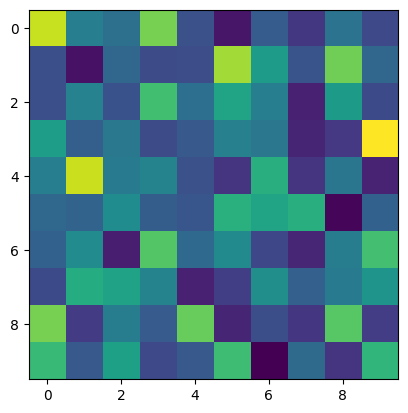

In [17]:
plt.imshow(at[0, 0].cpu().detach().numpy())

In [21]:
a = torch.arange(10).float()
b = torch.ones(10).float()


In [22]:
torch.einsum("i,j -> ij", a, b)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
        [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]])

In [30]:
a.reshape(-1, 1) @ b.reshape(1, -1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
        [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
        [7., 7., 7., 7., 7., 7., 7., 7., 7., 7.],
        [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]])

TinyStories_all_dat 100%[===================>]   1,50G  4,77MB/s    in 5m 37s  


In [3]:
rope = RoPE(dim=256, base=3)

torch.Size([128])


In [13]:
rope(batch).shape

torch.Size([32, 10, 128]) torch.Size([32, 10, 128])
torch.Size([10, 256])
torch.Size([32, 10, 128]) torch.Size([32, 10, 128])


torch.Size([32, 10, 256])

In [18]:
from model.decoder import Decoder

In [21]:
db = Decoder(256, 2, 2, 2, **{"use_rope": True, "rotary_base": 3})

In [8]:
import sentencepiece as spm

--2023-11-08 03:21:06--  https://raw.githubusercontent.com/google/sentencepiece/master/data/botchan.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278779 (272K) [text/plain]
Saving to: ‘botchan.txt’

botchan.txt         100%[===================>] 272,25K  --.-KB/s    in 0,1s    

2023-11-08 03:21:06 (2,13 MB/s) - ‘botchan.txt’ saved [278779/278779]



In [12]:
spm.SentencePieceTrainer.train("--input=/Users/bayesian_monster/llama/TinyStories.txt --model_prefix=llama --vocab_size=2000 --model_type=bpe")

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/Users/bayesian_monster/llama/TinyStories.txt --model_prefix=llama --vocab_size=2000 --model_type=bpe
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /Users/bayesian_monster/llama/TinyStories.txt
  input_format: 
  model_prefix: llama
  model_type: BPE
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos

KeyboardInterrupt: 

In [28]:
sp = spm.SentencePieceProcessor()
sp.load("llama.model")

True

In [32]:
print(sp.encode_as_pieces("Test"))
print(sp.EncodeAsIds("Test"))

['▁T', 'est']
[471, 601]


In [33]:
batch = ["test"] * 10

In [35]:
sp.EncodeAsIds(batch)

[[434, 601],
 [434, 601],
 [434, 601],
 [434, 601],
 [434, 601],
 [434, 601],
 [434, 601],
 [434, 601],
 [434, 601],
 [434, 601]]

In [6]:
import json
with open("/Users/bayesian_monster/llama/TinyStories_all_data/data00.json", mode="r") as f:
    index = json.load(f)

In [10]:
# story = []
# with open("/Users/bayesian_monster/llama/TinyStories.txt", "w") as f:
#     for i in range(len(index)):
#         f.write(index[i]["story"])
        

In [1]:
from tokenizer.tokenizer import Tokenizer
import numpy as np

In [2]:
tknz = Tokenizer("/Users/bayesian_monster/llama/TinyStoriesV3-GPT4-train.txt", 32000, "llama", "bpe")

In [3]:
tknz.load("/Users/bayesian_monster/llama/llama")

In [4]:
from pathlib import Path
import os 
train_path = Path("/Users/bayesian_monster/llama/train_files")
val_path = Path("/Users/bayesian_monster/llama/val_files")

with open("/Users/bayesian_monster/llama/TinyStoriesV3-GPT4-train.txt", "r") as file:
    i = 0
    for row in file:
        encoded = np.array(tknz.encode(row))
        path = train_path / f"{i + 1}.npy"
        np.save(path, encoded)
        i += 1

KeyboardInterrupt: 

In [94]:
tknz.tokenizer.pad()

AttributeError: 'SentencePieceProcessor' object has no attribute 'pad'

In [27]:
a = tknz.encode(["This is me", "asss"])

In [28]:
from torch.nn.utils.rnn import pad_sequence

[[1, 1154, 211, 275, 2], [1, 170, 289, 2]]

In [33]:
x = pad_sequence(map(lambda x: torch.tensor(x), a)).T

In [48]:
l = torch.nn.Embedding(num_embeddings=50, embedding_dim=100, padding_idx=0)

In [62]:
x.numpy().tolist()

[[1, 1154, 211, 275, 2], [1, 170, 289, 2, 0]]

In [64]:
tknz.decode(x.numpy().tolist())

['This is me', 'asss ⁇ ']

In [50]:
l(x)

IndexError: index out of range in self

In [85]:
with open("/Users/bayesian_monster/llama/TinyStories.txt", "r") as f:
    c = f.readlines()

In [169]:
from dataset.dataset import LLaMaDataset

In [171]:
dt = LLaMaDataset("TinyStories.txt", "/Users/bayesian_monster/llama/", 2000)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/Users/bayesian_monster/llama/TinyStories.txt --model_prefix=llama --vocab_size=2000 --model_type=bpe --user_defined_symbols=[PAD]
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /Users/bayesian_monster/llama/TinyStories.txt
  input_format: 
  model_prefix: llama
  model_type: BPE
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [PAD]
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0

In [177]:
dt.vocab.decode([4])

't'

In [101]:
tknz.encode("sas")

[1, 40, 2956, 2]

In [178]:
l(dt[0])

tensor([[-0.3360,  2.4695],
        [-1.3090,  0.3886],
        [-0.0666, -1.9801],
        [ 0.4612, -1.0595],
        [ 0.1188, -1.0825],
        [ 0.9645, -1.5288],
        [ 0.2070,  0.8887],
        [-0.0441, -0.1561],
        [ 1.0957, -0.7865],
        [ 1.1216, -0.6164],
        [-0.0540, -0.6910],
        [-1.0713, -0.7035],
        [-0.2244, -0.9473],
        [ 0.9645, -1.5288],
        [ 0.7791, -0.2654],
        [ 0.6706,  0.1540],
        [ 0.9800,  0.2608],
        [-0.5306, -1.3335],
        [ 1.8462, -2.4400],
        [ 1.6832,  0.5351],
        [ 0.6030,  0.9475],
        [ 0.2196, -0.8541],
        [-0.1392,  0.0823],
        [ 1.6832,  0.5351],
        [ 0.2797, -0.1501],
        [ 0.9645, -1.5288],
        [-0.3360,  2.4695],
        [-0.4890, -1.2180],
        [ 1.0957, -0.7865],
        [-0.1444,  1.4621],
        [-1.0713, -0.7035],
        [ 0.2797, -0.1501],
        [ 0.9645, -1.5288],
        [-0.4305,  0.7287],
        [ 1.4685,  0.7015],
        [ 2.2767, -1

In [179]:
from torch.utils.data import DataLoader
from dataset.dataset import collate_fn

In [180]:
jopa = DataLoader(dt, batch_size=10, shuffle=True, collate_fn=collate_fn)

In [181]:
l = torch.nn.Embedding(num_embeddings=3000, embedding_dim=2, padding_idx=-1)

In [182]:
l(torch.ones(2).int())

tensor([[-0.4028,  1.1555],
        [-0.4028,  1.1555]], grad_fn=<EmbeddingBackward0>)

In [185]:
next(iter(jopa))

{'sentence': tensor([[   1,   58,  815,  ...,    3,    3,    2],
         [   1,   36,  120,  ...,    3,    3,    2],
         [   1, 1150,  324,  ...,    3,    3,    2],
         ...,
         [   1, 1150,  324,  ...,  269, 1963,    2],
         [   1,  804, 1805,  ...,    3,    3,    2],
         [   1,  461, 1969,  ...,    3,    3,    2]], dtype=torch.int32)}

In [121]:
a

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [134]:
s = [torch.cat([torch.tensor([1]), a])] * 2

In [135]:
s = pad_sequence(s, batch_first=True)

In [138]:
torch.hstack([s, torch.ones(2)[:, None]])

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])